In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Carica il dataset
xlsx_file = 'dataset/richerDataset.xlsx'
df = pd.read_excel(xlsx_file)


In [2]:
# Pulisci il dataset
df = df[df['k_m2'] != 0]
df = df.drop(['Porosity_Tot', 'SSA_Tot'], axis=1)
df.reset_index(drop=True, inplace=True)

# Trasforma la colonna 'k_m2' con log10
df['k_m2'] = np.log10(df['k_m2'])


In [3]:
# Scala i dati
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
print(df_scaled)

    Conn.Dens.  Porosity       SSA       Ech  Tortuosity      k_m2
0     0.502894  0.422383  0.449469  0.933953    0.222507  0.476669
1     0.502894  0.458484  0.469240  0.919672    0.424816  0.526208
2     0.502894  0.400722  0.410769  0.950032    0.246553  0.694191
3     0.568572  0.342960  0.503944  0.865322    0.911510  0.427581
4     0.568572  0.429603  0.699968  0.626641    0.402373  0.421597
5     0.568572  0.342960  0.475339  0.914392    0.885220  0.473661
6     0.598718  0.411552  0.651909  0.686278    0.459763  0.325166
7     0.598718  0.425993  0.666842  0.699600    0.461366  0.591105
8     0.598718  0.346570  0.473131  0.895433    0.810516  0.508338
9     0.000000  0.000000  0.000000  0.994648    0.564283  0.292215
10    0.000000  0.000000  0.001577  1.000000    0.500160  0.298538
11    0.749909  0.913357  0.728783  0.721735    0.120872  0.898455
12    0.749909  0.830325  0.639289  0.793641    0.004168  0.855751
13    0.749909  0.884477  0.711852  0.742171    0.074703  0.89

In [4]:
# Prepara le feature e i target
features_X = df_scaled.drop(['k_m2'], axis=1)
targets_X = df_scaled[['k_m2']]

# Split dei dati
X_train, X_test, y_train, y_test = train_test_split(features_X, targets_X, test_size=0.2, random_state=42)



In [11]:
# Funzione per valutare il modello
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return r2, mse, mae, rmse, y_pred

# Parametri per la ricerca randomica
param_dist = {
    'n_estimators': [50, 100, 200, ],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [ 4, 5, 8, ],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7],
    'gamma': [0, 0.1, 0.2]
}


Fitting 37 folds for each of 486 candidates, totalling 17982 fits


C:\Users\loris\Desktop\Python Workspace\FirstTryMiller\venv\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan na

Migliori iperparametri trovati: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.8}
R^2: 0.5342123680004734
MSE: 0.011818807158405572
MAE: 0.08654113944410699
RMSE: 0.1087143374095872


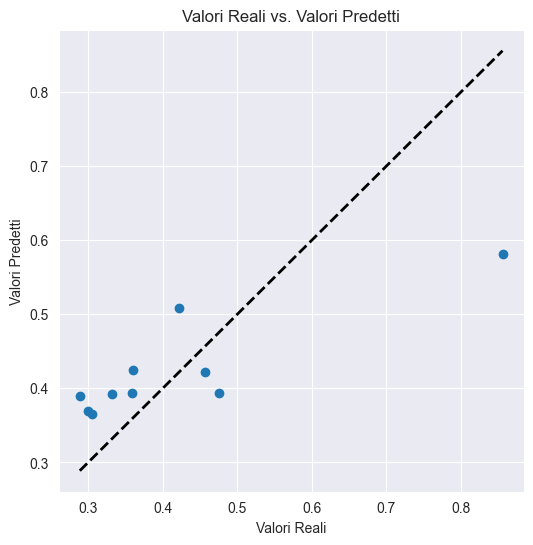

In [12]:
from sklearn.model_selection import LeaveOneOut, GridSearchCV

# Modello XGBoost
xgb = XGBRegressor(random_state=50)

loo = LeaveOneOut()

# Ricerca randomica degli iperparametri
grid_search = GridSearchCV(xgb, param_dist, scoring='r2', cv=loo, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

# Migliori iperparametri
best_model = grid_search.best_estimator_
print(f"Migliori iperparametri trovati: {grid_search.best_params_}")

# Valutazione del modello
r2, mse, mae, rmse, y_pred = evaluate_model(best_model, X_test, y_test)

print(f"R^2: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Plot dei valori reali vs. predetti
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Valori Reali vs. Valori Predetti')
plt.grid(True)
plt.show()